<a href="https://colab.research.google.com/github/lferncastro/Pneumonia-Predictor/blob/master/Pneumonia_classifier_from_chest_X_rays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credits: This notebook is based on the work of Debayan Das (Dexter 1618) [Github](https://github.com/Dexter1618/MMWML/tree/master/Week04)

In [0]:
!pip install -q kaggle
!pip install -q kaggle-cli
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!mkdir -p /content/drive/'My Drive'/datasets;cd /content/drive/'My Drive'/datasets; ls 
from pathlib import Path
kaggle_key = Path('/content/drive/My Drive/datasets/kaggle.json')
if kaggle_key.exists():
    !mkdir -p ~/.kaggle
    !cp /content/drive/'My Drive'/datasets/kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !ls ~/.kaggle
else:
    print('You need to upload the file kaggle.json')
    from google.colab import files
    uploaded = files.upload() 
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !mv kaggle.json /content/drive/'My Drive'/datasets/
    !chmod 600 ~/.kaggle/kaggle.json
    !ls ~/.kaggle

In [8]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/drive/'My Drive'/datasets/

 99% 1.14G/1.15G [00:12<00:00, 116MB/s]
100% 1.15G/1.15G [00:12<00:00, 97.1MB/s]


In [9]:
!cd /content/drive/'My Drive'/datasets/; unzip \*.zip
!unzip -q /content/drive/'My Drive'/datasets/chest_xray.zip 
!rm /content/drive/'My Drive'/datasets/*.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          


In [0]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

In [0]:
from pathlib import Path
train_path = "/content/drive/My Drive/datasets/chest_xray/train/"
test_path = "/content/drive/My Drive/datasets/chest_xray/test/"
valid_path = '/content/drive/My Drive/datasets/chest_xray/val/'
pos_class = "PNEUMONIA"
neg_class = "NORMAL"

In [42]:
P = Path(train_path + pos_class + "/")
tot=0
temp = list(P.glob("*.jpeg"))
tot=len(temp)
print("Training-Pneumonia - %i " % len(temp))
P = Path(train_path + neg_class + "/")
temp = list(P.glob("*.jpeg"))
tot+=len(temp)
print("Training-Normal - %i " % len(temp))
print("Training-Total - %i " % tot)
P = Path(test_path + pos_class + "/")
tot=0
temp = list(P.glob("*.jpeg"))
tot=len(temp)
print("Testing-Pneumonia - %i " % len(temp))
P = Path(test_path + neg_class + "/")
temp = list(P.glob("*.jpeg"))
tot+=len(temp)
print("Testing-Normal - %i " % len(temp))
print("Testing-Total - %i " % tot)
P = Path(valid_path + pos_class + "/")
tot=0
temp = list(P.glob("*.jpeg"))
tot=len(temp)
print("Validation-Pneumonia - %i " % len(temp))
P = Path(valid_path + neg_class + "/")
temp = list(P.glob("*.jpeg"))
tot+=len(temp)
print("Validation-Normal - %i " % len(temp))
print("Validation-Total - %i " % tot)

Training-Pneumonia - 3875 
Training-Normal - 1341 
Training-Total - 5216 
Testing-Pneumonia - 390 
Testing-Normal - 234 
Testing-Total - 624 
Validation-Pneumonia - 8 
Validation-Normal - 8 
Validation-Total - 16 


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [49]:
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
def plot_img(subset, category, labeled = False, sample_size = 3):
  full_path = dataset_path + subset + '/' + category
  if (sample_size > len([file for file in os.listdir(full_path)])):
      print(len([file for file in os.listdir('.') if os.path.isfile(file)]))
      print("Not enough files in ", full_path)
      return
  plt.figure(figsize=(10, 10))
  for i, file in enumerate(os.listdir(full_path)):
    if(i >= sample_size):
      break
    img = mpimg.imread(full_path + '/' + file)
    plt.subplot(131 + i)
    if labeled:
      plt.title(file.split('-')[1])
    plt.imshow(img)

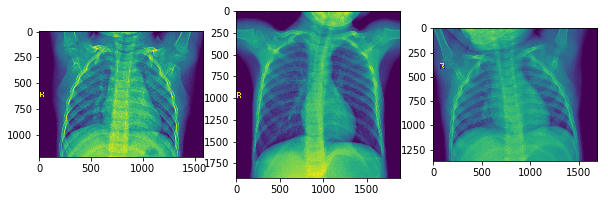

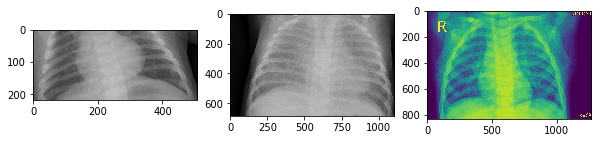

In [51]:
dataset_path = '/content/drive/My Drive/datasets/chest_xray/'
plot_img('train', 'NORMAL')
plot_img('train', 'PNEUMONIA')

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, BatchNormalization, Dense
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

In [20]:
base_model = InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))
base_model.trainable = False
myModel = Sequential([base_model,
                      GlobalAveragePooling2D(),
                      Dense(1024, activation = "relu"),
                      Dropout(0.3),
                      Dense(512, activation = "relu"),
                      Dropout(0.3),
                      Dense(256, activation = "relu"),
                      Dropout(0.3),
                      Dense(128, activation = "relu"),
                      Dropout(0.3),
                      Dense(1, activation = "sigmoid")])
myModel.compile(RMSprop(), loss = "binary_crossentropy", metrics = ["accuracy"])
myModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)              

In [24]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
y = train_generator.classes
labels = np.unique(y)
train_class_weights = compute_class_weight("balanced", labels, y)
train_class_weights

array([1.9448173 , 0.67303226])

In [25]:
history = myModel.fit_generator(train_generator, 
                                steps_per_epoch = len(train_generator),
                                epochs = 10,
                                verbose = 1,
                                workers = 20,
                                validation_data = validation_generator, 
                                validation_steps = len(validation_generator),
                                class_weight = train_class_weights)

Epoch 1/10
261/261 [==============================] - 211s 810ms/step - loss: 0.6070 - acc: 0.7418 - val_loss: 0.5744 - val_acc: 0.6795
Epoch 2/10
261/261 [==============================] - 86s 331ms/step - loss: 0.4209 - acc: 0.8215 - val_loss: 0.9145 - val_acc: 0.7163
Epoch 3/10
261/261 [==============================] - 85s 324ms/step - loss: 0.4173 - acc: 0.8340 - val_loss: 0.5829 - val_acc: 0.7292
Epoch 4/10
261/261 [==============================] - 87s 333ms/step - loss: 0.3912 - acc: 0.8461 - val_loss: 0.7646 - val_acc: 0.6651
Epoch 5/10
261/261 [==============================] - 87s 334ms/step - loss: 0.3958 - acc: 0.8485 - val_loss: 0.5848 - val_acc: 0.7244
Epoch 6/10
261/261 [==============================] - 86s 330ms/step - loss: 0.4457 - acc: 0.8438 - val_loss: 0.5907 - val_acc: 0.7019
Epoch 7/10
261/261 [==============================] - 86s 329ms/step - loss: 0.4218 - acc: 0.8581 - val_loss: 0.5599 - val_acc: 0.7179
Epoch 8/10
261/261 [==============================] - 

In [0]:
save_model(myModel, 'mdl_10', overwrite = True, include_optimizer = True)

In [0]:
myModel=load_model('mdl_10')

In [31]:
from sklearn.metrics import classification_report
pred = myModel.predict_generator(validation_generator, steps = len(validation_generator), verbose = 0)  
real = validation_generator.classes
mask = pred > 0.5
pred[mask] = 1
pred[~mask] = 0
print(classification_report(real, pred, target_names = [pos_class,neg_class]))

              precision    recall  f1-score   support

   PNEUMONIA       0.31      0.09      0.14       234
      NORMAL       0.62      0.87      0.72       390

    accuracy                           0.58       624
   macro avg       0.46      0.48      0.43       624
weighted avg       0.50      0.58      0.51       624

